In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [29]:
# Hyperparameters
batch_size = 64

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train_data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [30]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(8 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def _cnnForward(self,x):
        x = self.conv1(x)        
        x = self.pool(self.relu(x))
        return x
    
    def __Getsize_forFC(self):
        x = torch.rand((1, 1, 28, 28))
        with torch.no_grad():
            x = self._cnnForward(x)
        return x.reshape(-1,1).shape[0]
    
    def forward(self, x):
        x = self._cnnForward(x)
        x = x.view(-1, 8 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
# Train the model
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies


In [32]:
model = CNN().to(device)

learning_rate = 0.001
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/10], Train Loss: 0.3507, Train Accuracy: 90.25%, Val Loss: 0.1321, Val Accuracy: 96.22%
Epoch [2/10], Train Loss: 0.1082, Train Accuracy: 96.77%, Val Loss: 0.0976, Val Accuracy: 97.05%
Epoch [3/10], Train Loss: 0.0778, Train Accuracy: 97.67%, Val Loss: 0.0785, Val Accuracy: 97.61%
Epoch [4/10], Train Loss: 0.0613, Train Accuracy: 98.09%, Val Loss: 0.0706, Val Accuracy: 97.82%
Epoch [5/10], Train Loss: 0.0507, Train Accuracy: 98.41%, Val Loss: 0.0643, Val Accuracy: 98.12%
Epoch [6/10], Train Loss: 0.0428, Train Accuracy: 98.70%, Val Loss: 0.0650, Val Accuracy: 97.99%
Epoch [7/10], Train Loss: 0.0376, Train Accuracy: 98.86%, Val Loss: 0.0628, Val Accuracy: 98.15%
Epoch [8/10], Train Loss: 0.0316, Train Accuracy: 99.03%, Val Loss: 0.0681, Val Accuracy: 98.08%
Epoch [9/10], Train Loss: 0.0272, Train Accuracy: 99.17%, Val Loss: 0.0695, Val Accuracy: 98.12%
Epoch [10/10], Train Loss: 0.0224, Train Accuracy: 99.34%, Val Loss: 0.0717, Val Accuracy: 98.04%


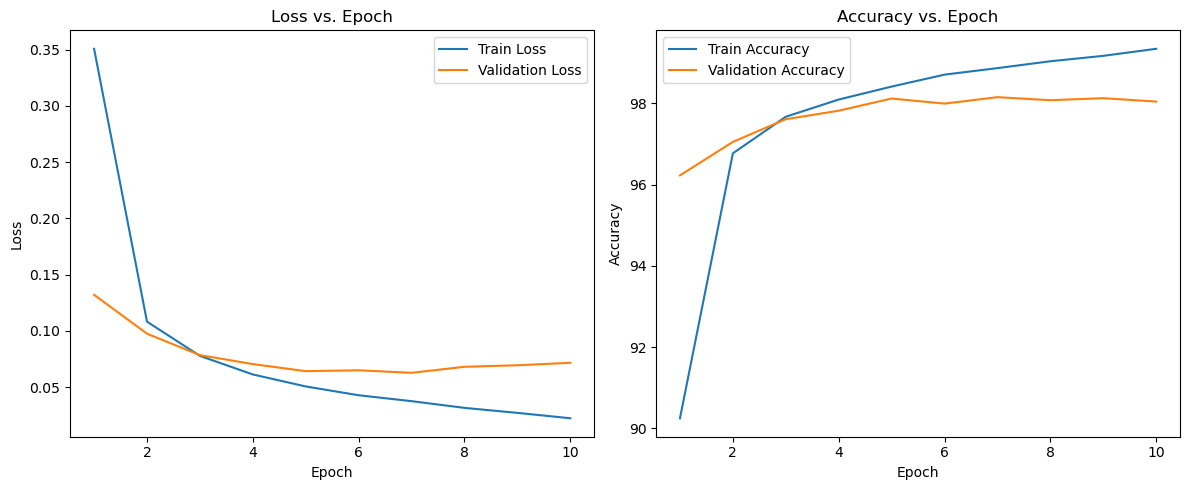

In [34]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()